#### Single Trial Analysis 
##### New Bonsai NWBs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [73]:
def load_csvs(dir: str) -> dict:
    """
    Load local CSV files into a dictionary.

    Params:
    dir (str): Directory containing local CSV files

    Returns:
    dict: Dictionary with CSV filenames as keys and DataFrames as values
    """

    # Convert to Path object
    local_path = Path(dir)

    # Regex pattern to match specific CSV filename format
    pattern = r'(\d+)_(\d{4}-\d{2}-\d{2})_fip_trials\.csv'

    processed_csvs = {}

    # Find and load matching CSV files
    for csv_file in local_path.glob('*.csv'):
        match = re.match(pattern, csv_file.name)
        if match:
            try:
                # Read CSV into DataFrame
                df = pd.read_csv(csv_file)
                
                # Use filename as key
                processed_csvs[csv_file.name] = df
                
            except Exception as e:
                print(f"Error processing {csv_file.name}: {str(e)}")

    if not processed_csvs:
        print(f"No matching CSV files found in {dir}")

    return processed_csvs

In [74]:
nwbs = load_csvs('/root/capsule/data/temp_fip_trials')

# Check dictionary 
nwbs.keys()

dict_keys(['714449_2024-06-11_fip_trials.csv', '757128_2024-10-07_fip_trials.csv', '757128_2024-09-20_fip_trials.csv', '757128_2024-10-08_fip_trials.csv', '713855_2024-06-07_fip_trials.csv', '757129_2024-10-07_fip_trials.csv', '757128_2024-10-03_fip_trials.csv', '757129_2024-09-19_fip_trials.csv', '714449_2024-06-21_fip_trials.csv', '757128_2024-10-04_fip_trials.csv', '711039_2024-08-09_fip_trials.csv', '757128_2024-09-18_fip_trials.csv', '731302_2024-09-25_fip_trials.csv', '714449_2024-06-27_fip_trials.csv', '740610_2024-08-21_fip_trials.csv', '757129_2024-09-26_fip_trials.csv', '711039_2024-08-08_fip_trials.csv', '757129_2024-09-18_fip_trials.csv', '732163_2024-08-08_fip_trials.csv', '731296_2024-09-23_fip_trials.csv', '750101_2024-08-23_fip_trials.csv', '714449_2024-06-18_fip_trials.csv', '750102_2024-08-23_fip_trials.csv', '746716_2024-10-07_fip_trials.csv', '746716_2024-10-04_fip_trials.csv', '757129_2024-09-20_fip_trials.csv', '746720_2024-10-02_fip_trials.csv', '740610_2024-08-2

In [75]:
# Group dictionary by subject_ids, session_dates
subject_dfs = {}

for filename, data, in nwbs.items():
    parts = filename.split('_')
    subject_id = parts[0]
    session_date = parts[1]

    session_date = datetime.strptime(session_date, '%Y-%m-%d')

    data['session_date'] = session_date

    if subject_id not in subject_dfs:
        subject_dfs[subject_id] = []

    subject_dfs[subject_id].append(data)

# Concatenate unique subject_ids together, sort by date 
for subject_id in subject_dfs:
    subject_data = pd.concat(subject_dfs[subject_id], ignore_index=True)

    subject_data = subject_data.sort_values(by='session_date')

    subject_data = subject_data.reset_index(drop=True)

    subject_dfs[subject_id] = subject_data

In [76]:
subject_dfs['700708']['auto_train_stage'].unique()

array(['STAGE_FINAL', 'STAGE_3', 'STAGE_1'], dtype=object)

In [77]:
stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL']

test = subject_dfs['700708'].loc[:, ['trial', 'animal_response', 'reward_probabilityL', 'reward_probabilityR', 'auto_train_stage']]

test['auto_train_stage'] = pd.Categorical(test['auto_train_stage'], categories=stage_vector, ordered=True)

test = test.sort_values(by='auto_train_stage')

test.head(60)

,trial,animal_response,reward_probabilityL,reward_probabilityR,auto_train_stage
1620,364,1.0,0.0,0.8,STAGE_1
1475,507,1.0,0.8,0.0,STAGE_1
1474,436,1.0,0.0,0.8,STAGE_1
1473,416,0.0,0.8,0.0,STAGE_1
1472,415,0.0,0.8,0.0,STAGE_1
1471,414,0.0,0.8,0.0,STAGE_1
1470,413,0.0,0.8,0.0,STAGE_1
1469,412,0.0,0.8,0.0,STAGE_1
1476,543,0.0,0.8,0.0,STAGE_1
1468,411,0.0,0.8,0.0,STAGE_1


In [78]:
# Probability chosen metric calculation 

def calculate_probabilities(row):
    # No response results in a NaN value
    if row.animal_response == 2:
        return np.nan, np.nan
    # Chosen = left choice left probability, not chosen = left choice right probability 
    elif row.animal_response == 0:
        return row.reward_probabilityL, row.reward_probabilityR
    else: # Chosen = right choice right probability, not chosen = right choice left probability 
        return row.reward_probabilityR, row.reward_probabilityL


In [79]:
# global mins and maxes need to be calculated on a stage level due to differences in probabilites between FINAL and rest
# normalize at block level 

def chosen_metric(df):
    # Calculate the difference for each row
    average = (df['probability_chosen'] - df['probability_not_chosen'])
    
    # Find global maximum
    p_larger_global = max(df['probability_chosen'].max(), df['probability_not_chosen'].max())
    
    # Find global minimum
    p_smaller_global = min(df['probability_chosen'].min(), df['probability_not_chosen'].min())
    
    # Calculate mean of the differences
    mean_difference = average.mean()
    
    # Calculate final metric
    final_metric = mean_difference / (p_larger_global - p_smaller_global)
   
    return(final_metric)

In [80]:
def process_subject_data(subject_dfs):
    """ 
    Process subject DataFrames to calculate probabilities and chosen metrics for each session / subject_id

    Params:
    subject_dfs (dict): Dictionary containing subject_id DataFrames

    Returns:
    processed_dfs (dict): Dictionary containing subject_id DataFrames with probability and chosen metrics
    """ 

    all_summaries = []

    for subject_id, subject_data in subject_dfs.items():
        # Group data by session date
        grouped_data = subject_data.groupby('session_date')

        # Initialize lists to store results 
        session_dates = []
        metrics = []
        stages = []

        for session_date, session_group in grouped_data:
            # Calculate probabilities for current session
            prob_chosen, prob_not_chosen = zip(*session_group.apply(calculate_probabilities, axis=1))

            # Create temporary dataframe to store calculations
            temp_df = pd.DataFrame({
                'probability_chosen': prob_chosen,
                'probability_not_chosen': prob_not_chosen
            })

            # Find chosen metric for this session
            session_metric = chosen_metric(temp_df)

            # Get stage for this session
            stage = session_group['auto_train_stage'].iloc[0]

            # Store result
            session_dates.append(session_date)
            metrics.append(session_metric)
            stages.append(stage)

            # Add probability columns
            subject_data.loc[session_group.index, 'probability_chosen'] = prob_chosen
            subject_data.loc[session_group.index, 'probability_not_chosen'] = prob_not_chosen

        # Create summary dataframe for this subject
        summary_df = pd.DataFrame({
            'subject_id': subject_id,
            'session_date': session_dates,
            'chosen_metric': metrics,
            'auto_train_stage': stages
        })

        summary_df = summary_df.sort_values('session_date')

        # Add session column
        summary_df['session'] = range(1, len(summary_df) + 1)

        all_summaries.append(summary_df)

    processed_df = pd.concat(all_summaries, ignore_index=True)

    return processed_df

In [81]:
processed_results = process_subject_data(subject_dfs)
processed_results['subject_id'] = processed_results['subject_id'].astype('int64')

processed_results

,subject_id,session_date,chosen_metric,auto_train_stage,session
0,714449,2024-06-11,0.190164,STAGE_2,1
1,714449,2024-06-18,0.483037,STAGE_1,2
2,714449,2024-06-21,0.401070,STAGE_1,3
3,714449,2024-06-26,0.179104,STAGE_1,4
4,714449,2024-06-27,0.497963,STAGE_2,5
...,...,...,...,...,...
310,711041,2024-08-09,-0.005568,STAGE_FINAL,3
311,711041,2024-08-12,0.127711,STAGE_FINAL,4
312,711041,2024-08-14,-0.016588,STAGE_FINAL,5
313,708026,2024-07-18,-0.030641,STAGE_1,1


In [82]:
curriculum = 'coupled_baiting'

processed_results = processed_results[processed_results['task_type'] == curriculum]

KeyError: 'task_type'

In [83]:
# Load in session level metrics 

session_metrics = pd.read_csv('/root/capsule/data/filtered_data_session/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/tmp/ipykernel_12389/2351227263.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/root/capsule/data/filtered_data_session/filtered_data_20241107.csv')


In [84]:
session_metrics['curriculum_name'].unique()

array(['Uncoupled Baiting', nan, 'Uncoupled Without Baiting',
       'Coupled Baiting'], dtype=object)

In [90]:
main_df = bu.merge_dataframes_subject_id(processed_results, session_metrics)

print(main_df['curriculum_name'].unique())

main_df

['Uncoupled Without Baiting' 'Uncoupled Baiting' 'Coupled Baiting']


,subject_id,session_date,chosen_metric,auto_train_stage,session_x,nwb_suffix,session_y,rig,user_name,curriculum_name,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,714449,2024-06-11,0.190164,STAGE_2,1,103912,2.0,447-1-D,Travis Ramirez,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': [], 'ap': '-5.4', 'ml...",Coupled Without Baiting,[],[],behavior_714449_2024-06-11_10-39-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/0...,10-39-12,2_uploaded and processed
1,714449,2024-06-18,0.483037,STAGE_1,2,110920,6.0,447-1-D,Travis Ramirez,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': [], 'ap': '-5.4', 'ml...",Coupled Baiting,[],[],behavior_714449_2024-06-18_11-09-20_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,11-09-20,2_uploaded and processed
2,714449,2024-06-21,0.401070,STAGE_1,3,110500,8.0,447-1-D,Travis Ramirez,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': [], 'ap': '-5.4', 'ml...",Coupled Baiting,[],[],behavior_714449_2024-06-21_11-05-00_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/a...,11-05-00,2_uploaded and processed
3,714449,2024-06-26,0.179104,STAGE_1,4,93321,10.0,447-3-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': [], 'ap': '-5.4', 'ml...",Coupled Baiting,[],[],behavior_714449_2024-06-26_09-33-21_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/0...,09-33-21,2_uploaded and processed
4,714449,2024-06-27,0.497963,STAGE_2,5,92338,11.0,447-3-D,Henry Loeffler,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': [], 'ap': '-5.4', 'ml...",Coupled Without Baiting,[],[],behavior_714449_2024-06-27_09-23-38_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/7...,09-23-38,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,711041,2024-08-09,-0.005568,STAGE_FINAL,3,132520,17.0,447-3-D,Jaimie Kenney,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Uncoupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711041_2024-08-09_13-25-20_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/7...,13-25-20,2_uploaded and processed
311,711041,2024-08-12,0.127711,STAGE_FINAL,4,130814,18.0,447-3-D,Jaimie Kenney,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Uncoupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711041_2024-08-12_13-08-14_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,13-08-14,2_uploaded and processed
312,711041,2024-08-14,-0.016588,STAGE_FINAL,5,132332,19.0,447-3-D,Jaimie Kenney,Uncoupled Without Baiting,...,Dbh-Cre-KI/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...",[{'injection_materials': ['pAAV-syn-FLEX-jGCaM...,Uncoupled Without Baiting,"['pAAV-syn-FLEX-jGCaMP8m-WPRE', 'pAAV-syn-FLEX...","['-5.2,0.85,-3.1', '-5.2,-0.85,-3.1']",behavior_711041_2024-08-14_13-23-32_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/a...,13-23-32,2_uploaded and processed
313,708026,2024-07-18,-0.030641,STAGE_1,1,94618,2.0,446-6-D,margaret lee,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'angle': '0.0', 'angle_unit': 'degrees', 'br...","[{'injection_materials': ['TBA', 'TBA'], 'ap':...",Coupled Baiting,['TBA'],[],behavior_708026_2024-07-18_09-46-18_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg

In [91]:
curriculum = 'Coupled Baiting'

main_df = main_df[main_df['curriculum_name'] == curriculum]

main_df

,subject_id,session_date,chosen_metric,auto_train_stage,session_x,nwb_suffix,session_y,rig,user_name,curriculum_name,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
172,705599,2024-06-07,0.257778,STAGE_3,1,134108,5.0,447-1-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['pAAV.CAG.Flex.NES-J...,Coupled Baiting,"['pAAV.CAG.Flex.NES-JRGECO1a.WPRE.SV40', 'AAV-...","['NE', 'DA']",behavior_705599_2024-06-07_13-41-08_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/2...,13-41-08,2_uploaded and processed
173,705599,2024-06-12,0.204399,STAGE_FINAL,2,132255,8.0,447-1-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['pAAV.CAG.Flex.NES-J...,Coupled Baiting,"['pAAV.CAG.Flex.NES-JRGECO1a.WPRE.SV40', 'AAV-...","['NE', 'DA']",behavior_705599_2024-06-12_13-22-55_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,13-22-55,2_uploaded and processed
174,705599,2024-06-24,0.034612,STAGE_FINAL,3,131653,11.0,447-1-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['pAAV.CAG.Flex.NES-J...,Coupled Baiting,"['pAAV.CAG.Flex.NES-JRGECO1a.WPRE.SV40', 'AAV-...","['NE', 'DA']",behavior_705599_2024-06-24_13-16-53_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/6...,13-16-53,2_uploaded and processed
175,705599,2024-06-26,-0.069103,STAGE_FINAL,4,130427,13.0,447-1-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['pAAV.CAG.Flex.NES-J...,Coupled Baiting,"['pAAV.CAG.Flex.NES-JRGECO1a.WPRE.SV40', 'AAV-...","['NE', 'DA']",behavior_705599_2024-06-26_13-04-27_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/6...,13-04-27,2_uploaded and processed
176,705599,2024-06-27,0.171951,STAGE_FINAL,5,122252,14.0,447-1-D,Jaimie Kenney,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['pAAV.CAG.Flex.NES-J...,Coupled Baiting,"['pAAV.CAG.Flex.NES-JRGECO1a.WPRE.SV40', 'AAV-...","['NE', 'DA']",behavior_705599_2024-06-27_12-22-52_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/7...,12-22-52,2_uploaded and processed
215,700708,2024-06-04,0.258333,STAGE_FINAL,1,84422,41.0,447-1-D,Huy Nguyen,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['AAV5-hSynapsin1-FLE...,Coupled Baiting,"['AAV5-hSynapsin1-FLEx-axon-GCaMP6s', 'AAV-PHP...","['-3.05,-0.6,-4.3', 'DA']",behavior_700708_2024-06-04_08-44-22_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/e...,08-44-22,2_uploaded and processed
216,700708,2024-06-07,0.212500,STAGE_FINAL,2,85839,44.0,447-1-D,Ella Hilton,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['AAV5-hSynapsin1-FLE...,Coupled Baiting,"['AAV5-hSynapsin1-FLEx-axon-GCaMP6s', 'AAV-PHP...","['-3.05,-0.6,-4.3', 'DA']",behavior_700708_2024-06-07_08-58-39_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/7...,08-58-39,2_uploaded and processed
217,700708,2024-06-10,0.426637,STAGE_3,3,84713,45.0,447-1-D,Ella Hilton,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['AAV5-hSynapsin1-FLE...,Coupled Baiting,"['AAV5-hSynapsin1-FLEx-axon-GCaMP6s', 'AAV-PHP...","['-3.05,-0.6,-4.3', 'DA']",behavior_700708_2024-06-10_08-47-13_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/6...,08-47-13,2_uploaded and processed
218,700708,2024-06-20,0.236593,STAGE_1,4,91458,49.0,447-1-D,Huy Nguyen,Coupled Baiting,...,Slc6a3-IRES-Cre_Bkmn/wt,"[{'targeted_structure': None, 'stereotactic_co...",[{'injection_materials': ['AAV5-hSyn

In [94]:
main_df['auto_train_stage'].unique()

array(['STAGE_3', 'STAGE_FINAL', 'STAGE_1'], dtype=object)

<Axes: xlabel='session_x', ylabel='chosen_metric'>

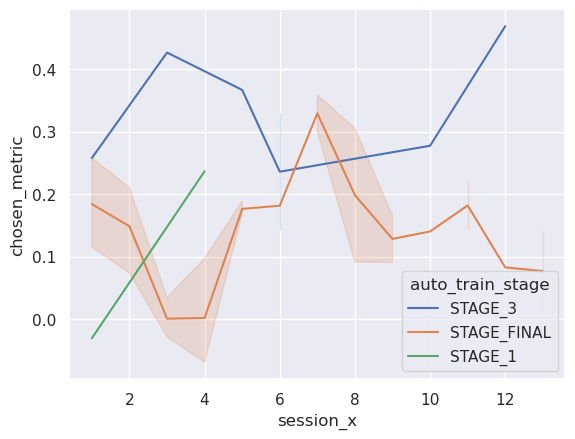

In [93]:
sns.lineplot(main_df, x='session_x', y='chosen_metric', hue='auto_train_stage')

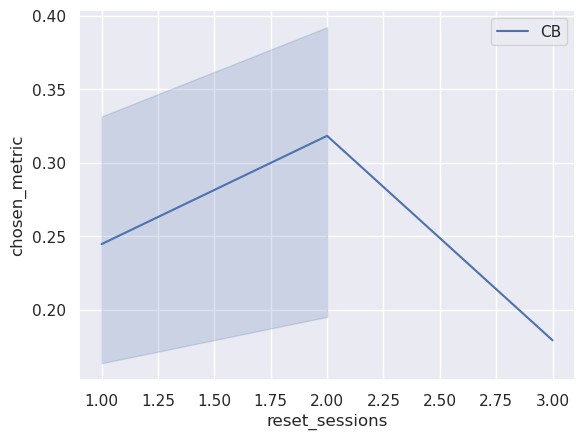

In [ ]:
cb_data = task_dict['Coupled Baiting']
ub_data = task_dict['Uncoupled Baiting']
cwb_data = task_dict['Coupled Without Baiting']
uwb_data = task_dict['Uncoupled Without Baiting']

sns.lineplot(cb_data, x='reset_sessions', y='chosen_metric', label='CB')
sns.lineplot(ub_data, x='reset_sessions', y='chosen_metric', label='UB')
sns.lineplot(cwb_data, x='reset_sessions', y='chosen_metric',label='CWB')
sns.lineplot(uwb_data, x='reset_sessions', y='chosen_metric', label='UWB')
plt.legend()
plt.show()